# Heart beats classification problem
A typical task for applied Machine Learning in medicine is an automatic classification of signals from diagnostic devices such as ECG or EEG

Typical pipeline:
- detect QRS compexes (beats)
- classify them:
> - normal beat N
> - arrhytmia, e.g. *venticular* V, *supraventicular* S arrytmia, or *artial fibrillation* AF

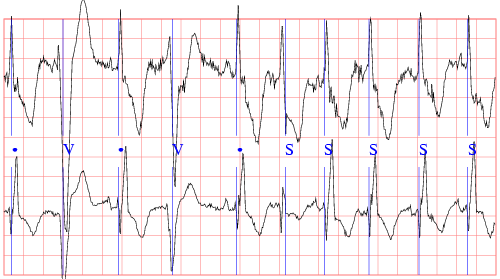

![ECG signal](https://ars.els-cdn.com/content/image/1-s2.0-S0950705120307188-gr1.jpg)

a couple of links:
- [exemplary challenge from Physionet](https://physionet.org/content/challenge-2017/1.0.0/)
- [some recent paper on ECG classification](https://doi.org/10.1016/j.knosys.2020.106589)

## our challenge: classify beats as normal or abnormal (arrhytmia)
- we will utilize signals from **svdb** database, and grab subsequent beats (data preprocessing)
- then construct binary classifier using NN, decision trees, ensemble metchods, and SVM or NaiveBayes

# Dataset preparation
1. Download ecg waves from **svdb** database provided by *PhysioNet*
2. Divide signals into samples, each containing single heartbeat (with window size of 96 points, *sampling ratio* = 128 points/s)
3. Take only samples annotated as 'N' (normal beat), or 'S' and 'V' (arrhythmias)

In [ ]:
import os
import numpy as np

# install PhysioNet ecg data package 
!pip install wfdb
import wfdb

# list of available datasets
dbs = wfdb.get_dbs()
display(dbs)

# we choose svdb
svdb_dir = os.path.join(os.getcwd(), 'svdb_dir')
wfdb.dl_database('svdb', dl_dir=svdb_dir)

# Display the  downloaded content
svdb_in_files = [os.path.splitext(f)[0] for f in os.listdir(svdb_dir) if f.endswith('.dat')]
print(svdb_in_files)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 KB 7.3 MB/s eta 0:00:00
  Attempting uninstall: SoundFile
    Found existing installation: soundfile 0.12.1
    Uninstalling soundfile-0.12.1:
      Successfully uninstalled soundfile-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.


[['aami-ec13', 'ANSI/AAMI EC13 Test Waveforms'],
 ['accelerometry-walk-climb-drive',
  'Labeled raw accelerometry data captured during walking, stair climbing and driving'],
 ['actes-cycloergometer-exercise',
  'Cardiorespiratory measurement from graded cycloergometer exercise testing'],
 ['adfecgdb', 'Abdominal and Direct Fetal ECG Database'],
 ['afdb', 'MIT-BIH Atrial Fibrillation Database'],
 ['afpdb', 'PAF Prediction Challenge Database'],
 ['aftdb', 'AF Termination Challenge Database'],
 ['ahadb', 'AHA Database Sample Excluded Record'],
 ['annotation-opioid-use-notes',
  'Annotation dataset of problematic opioid use and related contexts from MIMIC-III Critical Care Database discharge summaries'],
 ['antimicrobial-resistance-uti',
  'AMR-UTI: Antimicrobial Resistance in Urinary Tract Infections'],
 ['apnea-ecg', 'Apnea-ECG Database'],
 ['auditory-eeg', 'Auditory evoked potential EEG-Biometric dataset'],
 ['autonomic-aging-cardiovascular',
  'Autonomic Aging: A dataset to quantify ch

Generating record list for: 800
Generating record list for: 801
Generating record list for: 802
Generating record list for: 803
Generating record list for: 804
Generating record list for: 805
Generating record list for: 806
Generating record list for: 807
Generating record list for: 808
Generating record list for: 809
Generating record list for: 810
Generating record list for: 811
Generating record list for: 812
Generating record list for: 820
Generating record list for: 821
Generating record list for: 822
Generating record list for: 823
Generating record list for: 824
Generating record list for: 825
Generating record list for: 826
Generating record list for: 827
Generating record list for: 828
Generating record list for: 829
Generating record list for: 840
Generating record list for: 841
Generating record list for: 842
Generating record list for: 843
Generating record list for: 844
Generating record list for: 845
Generating record list for: 846
Generating record list for: 847
Generati

In [ ]:
time_window = 48
all_beats = []
all_annotations = []
for in_file in svdb_in_files:
    print('...processing...' + in_file + '...file')
    signal, fields = wfdb.rdsamp(os.path.join(svdb_dir,in_file), channels=[0])
    annotations = wfdb.rdann(os.path.join(svdb_dir,in_file), 'atr')
    signal=np.array(signal).flatten()
    # grab subsequent heartbeats within [position-48,position+48] window
    beats = np.zeros((len(annotations.sample[5:-5]), time_window*2))
    # note that we remove first and last few beats to ensure that all beats have equal lengths
    for i, ann_position in enumerate(annotations.sample[5:-5]):
        beats[i] = signal[ann_position-time_window:ann_position+time_window]
    all_beats.append(beats)
    # consequently, we remove first and last few annotations
    all_annotations.append(annotations.symbol[5:-5])

all_beats = np.concatenate(all_beats)
all_annotations = np.concatenate(all_annotations)

# check which annotations are usable for us, are of N or S or V class
indices = [i for i, ann in enumerate(all_annotations) if ann in {'N','S','V'}]
# and get only these
all_beats = all_beats[indices]
all_annotations = np.array([all_annotations[i] for i in indices])

# print data statistics
print(all_beats.shape, all_annotations.shape)
print('no of N beats: ' + str(np.count_nonzero(all_annotations == 'N')))
print('no of S beats: ' + str(np.count_nonzero(all_annotations == 'S')))
print('no of V beats: ' + str(np.count_nonzero(all_annotations == 'V')))

...processing...872...file
...processing...804...file
...processing...877...file
...processing...867...file
...processing...881...file
...processing...894...file
...processing...855...file
...processing...805...file
...processing...886...file
...processing...851...file
...processing...820...file
...processing...809...file
...processing...826...file
...processing...840...file
...processing...810...file
...processing...887...file
...processing...885...file
...processing...876...file
...processing...825...file
...processing...841...file
...processing...861...file
...processing...862...file
...processing...849...file
...processing...853...file
...processing...889...file
...processing...883...file
...processing...845...file
...processing...829...file
...processing...859...file
...processing...858...file
...processing...854...file
...processing...852...file
...processing...812...file
...processing...868...file
...processing...875...file
...processing...888...file
...processing...803...file
.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.1.3-cp39-cp39-linux_x86_64.whl size=12062445 sha256=85cc893456245fb8b83890c3f62e54d71c1eb9d1d9fe683fc852df19c423bdd8
  Stored in directory: /root/.cache/pip/wheels/88/5f/33/d7b8943eba74fdfbd535c83cefcf366c25b0f9cb6424e763e7
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 4.1.0 requires matplotlib<4.0.0,>=3.2.2, but you have matplotlib 3.1.3 which is incompatible.
plotnine 0.10.1 requires matpl

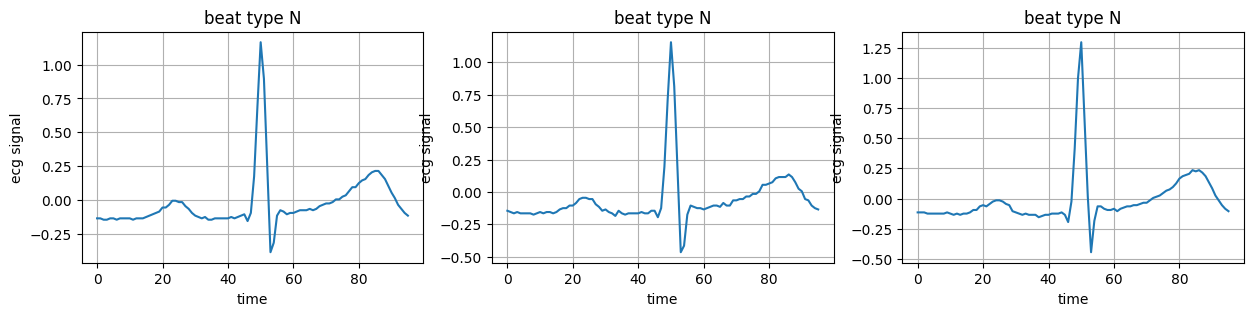

In [ ]:
# show example samples
!pip install matplotlib==3.1.3
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3)
fig.set_size_inches(15, 3)
plt.subplots_adjust(wspace=0.2)
print(all_annotations[:100])
sample_number = [0,6,8]
for i, sn in enumerate(sample_number):
    ax[i].plot(all_beats[sn])
    ax[i].set(xlabel='time', ylabel='ecg signal', title='beat type ' + all_annotations[sn])
    ax[i].grid()
plt.show()

# Experiments

0. Preliminaries
> - Divide dataset into train/validation/test subset, and normalize each of them. 
> - Define classification accuracy metrics (dataset is imbalanced)
>>Confusion matrix
```
____Prediction
T |   n  s  v
r |N  Nn Ns Nv
u |S  Sn Ss Sv
t |V  Vn Vs Vv
h | 
```
>> - Total accuracy
$Acc_T = \frac{Nn+Ss+Vv}{\Sigma_N+\Sigma_S+\Sigma_V}$,
>> - Arrhythmia accuracy (S or V cases are more important to be detected):
$Acc_A = \frac{Ss+Vv}{\Sigma_S+\Sigma_V}$,
>> - $\Sigma_N=Nn+Ns+Nv$, $\Sigma_S=Sn+Ss+Sv$,
$\Sigma_V=Vn+Vs+Vv$

1. Standard classifiers: *naive Bayes* and *SVM*
2. Decision Tree with optimized max_depth
3. Random Forest with vector of features

In [ ]:
# prepare datasets and define error metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# to simplify experiments and speedup training 
# we take only some part of the whole dataset
X, y = all_beats[::10], all_annotations[::10]

# train/validation/test set splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=0)
print(len(y_train), len(y_val), len(y_test))

# perform data normalization: z = (x - u)/s
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
# same for the validation subset
X_val = preprocessing.StandardScaler().fit_transform(X_val)
# and for the test subset
X_test = preprocessing.StandardScaler().fit_transform(X_test)

# define accuracy
def calculate_accuracy(y_pred, y_gt, comment='', printout=True):
    acc_t = np.count_nonzero(y_pred == y_gt)/len(y_gt)
    acc_a = np.count_nonzero(
        np.logical_and(y_pred == y_gt, y_gt != 'N'))/np.count_nonzero(y_gt != 'N')
    if printout is True:
        print('-----------------------------------')    
        print(comment)
        print('Total accuracy, Acc_T = {:.4f}'.format(acc_t))
        print('Arrhythmia accuracy, Acc_A = {:.4f}'.format(acc_a))
        print('-----------------------------------')
    else: return acc_t, acc_a 

12859 2756 2756


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='naive Bayes classifier')

svc = SVC()
y_pred = svc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='SVM classifier')

svc = SVC(class_weight='balanced')
y_pred = svc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='balanced SVM classifier')

-----------------------------------
naive Bayes classifier
Total accuracy, Acc_T = 0.8291
Arrhythmia accuracy, Acc_A = 0.3962
-----------------------------------
-----------------------------------
SVM classifier
Total accuracy, Acc_T = 0.9459
Arrhythmia accuracy, Acc_A = 0.5566
-----------------------------------
-----------------------------------
balanced SVM classifier
Total accuracy, Acc_T = 0.9372
Arrhythmia accuracy, Acc_A = 0.7925
-----------------------------------


Summary of this part:
1. The goal is to maximize both metrics Acc_T and Acc_A at the same time
1. naive Bayes performs rather poorly
> - problem with data imbalace
2. SVM has simillar problem, but after data balacing works quite good

#First way to improve our accuracies

-----------------------------------
decision tree classifier
Total accuracy, Acc_T = 0.8062
Arrhythmia accuracy, Acc_A = 0.6855
-----------------------------------
1 0.8592 0.2428
2 0.0860 0.7572
3 0.8280 0.3994
4 0.7841 0.4473
5 0.8306 0.4696
6 0.7326 0.5974
7 0.8429 0.5783
8 0.8443 0.6038
9 0.8679 0.5879
10 0.8073 0.6198
11 0.8795 0.5974
12 0.8621 0.5974
13 0.8861 0.6038
14 0.8730 0.6102
15 0.8687 0.6070
16 0.8933 0.5719
17 0.8788 0.5751
18 0.8875 0.5879
19 0.8937 0.5559
20 0.9009 0.5527
21 0.9104 0.5591
22 0.9086 0.5431
23 0.9078 0.5495
24 0.9089 0.5655
25 0.9140 0.5623


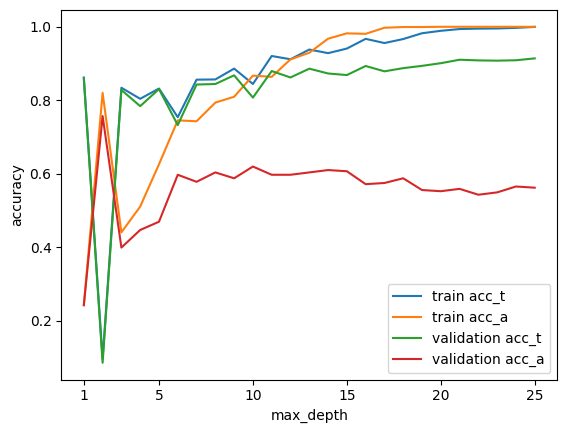

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='entropy', 
                             splitter='best', 
                             max_depth=10, 
                             min_samples_split=2, 
                             min_samples_leaf=1,
                             class_weight='balanced')


y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='decision tree classifier')


# tunning max_dept hyperparameter (DT likes to overfit)
train_acc_t = []
train_acc_a = []
val_acc_t = []
val_acc_a = []
depth_range = range(1,26)
for max_depth in depth_range:
    dtc = DecisionTreeClassifier(criterion='entropy', 
                             splitter='best', 
                             max_depth=max_depth, 
                             min_samples_split=2, 
                             min_samples_leaf=1,
                             class_weight='balanced')
    dt_fit = dtc.fit(X_train, y_train)
    y_pred_train = dt_fit.predict(X_train)
    y_pred_val = dt_fit.predict(X_val)    
    acc_t_train, acc_a_train = calculate_accuracy(y_pred_train, y_train, printout=False)
    acc_t_val, acc_a_val = calculate_accuracy(y_pred_val, y_val, printout=False)
    train_acc_t.append(acc_t_train)
    train_acc_a.append(acc_a_train)
    val_acc_t.append(acc_t_val)
    val_acc_a.append(acc_a_val)
    print('{0:d} {1:.4f} {2:4.4f}'.format(max_depth, acc_t_val, acc_a_val))

import matplotlib.pyplot as plt
_, ax = plt.subplots()
ax.plot(depth_range, train_acc_t, label='train acc_t')
ax.plot(depth_range, train_acc_a, label='train acc_a')
ax.plot(depth_range, val_acc_t, label='validation acc_t')
ax.plot(depth_range, val_acc_a , label='validation acc_a')
ax.set(xlabel='max_depth', ylabel='accuracy')
ax.xaxis.set_ticks([1, 5, 10, 15, 20, 25])
ax.legend()
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='gini', 
                             class_weight='balanced', 
                             min_samples_split=100, 
                             max_depth=5, 
                             random_state=42)

y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='decision tree classifier')


-----------------------------------
decision tree classifier
Total accuracy, Acc_T = 0.7765
Arrhythmia accuracy, Acc_A = 0.5692
-----------------------------------


This code will train a Decision Tree Classifier with different combinations of hyperparameters using Grid Search, and select the best hyperparameters based on cross-validation performance.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create the Grid Search object
dtc = DecisionTreeClassifier(class_weight='balanced', criterion='entropy')
grid_search = GridSearchCV(dtc, param_grid=param_grid, cv=5)

# Train the model using Grid Search
grid_search.fit(X_train, y_train)

# Make predictions on the test set
y_pred = grid_search.predict(X_test)

# Calculate the accuracy
calculate_accuracy(y_pred, y_test, comment='Decision Tree Classifier with Grid Search')


-----------------------------------
Decision Tree Classifier with Grid Search
Total accuracy, Acc_T = 0.9133
Arrhythmia accuracy, Acc_A = 0.6132
-----------------------------------


1 0.8592 0.2428
2 0.0860 0.7572
3 0.8280 0.3994
4 0.7856 0.4409
5 0.8313 0.4760
6 0.7290 0.6070
7 0.8335 0.5911
8 0.8306 0.6294
9 0.8578 0.6102
10 0.7848 0.6613
11 0.8327 0.6613
12 0.8545 0.6550
13 0.8233 0.6997
14 0.8320 0.6805
15 0.8280 0.6677
16 0.8454 0.6613
17 0.8324 0.6645
18 0.8342 0.6677
19 0.8451 0.6645
20 0.8447 0.6550
21 0.8469 0.6581
22 0.8469 0.6581
23 0.8454 0.6581
24 0.8447 0.6613
25 0.8501 0.6613


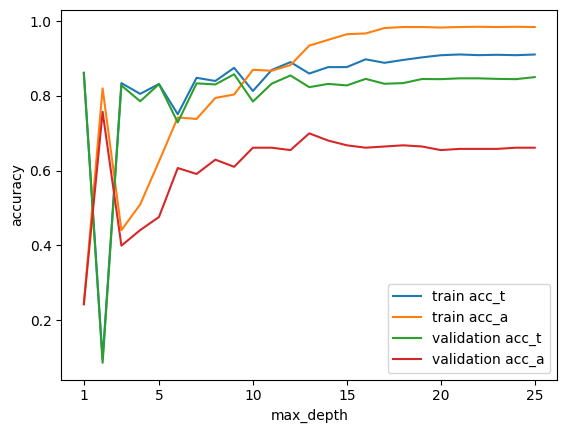

In [ ]:
# tunning max_dept hyperparameter (DT likes to overfit)
train_acc_t = []
train_acc_a = []
val_acc_t = []
val_acc_a = []
depth_range = range(1,26)
for max_depth in depth_range:
    dtc = DecisionTreeClassifier(criterion='entropy', 
                                 class_weight='balanced', 
                                 min_samples_leaf=10,
                                 max_depth=max_depth)
    dt_fit = dtc.fit(X_train, y_train)
    y_pred_train = dt_fit.predict(X_train)
    y_pred_val = dt_fit.predict(X_val)    
    acc_t_train, acc_a_train = calculate_accuracy(y_pred_train, y_train, printout=False)
    acc_t_val, acc_a_val = calculate_accuracy(y_pred_val, y_val, printout=False)
    train_acc_t.append(acc_t_train)
    train_acc_a.append(acc_a_train)
    val_acc_t.append(acc_t_val)
    val_acc_a.append(acc_a_val)
    print('{0:d} {1:.4f} {2:4.4f}'.format(max_depth, acc_t_val, acc_a_val))

import matplotlib.pyplot as plt
_, ax = plt.subplots()
ax.plot(depth_range, train_acc_t, label='train acc_t')
ax.plot(depth_range, train_acc_a, label='train acc_a')
ax.plot(depth_range, val_acc_t, label='validation acc_t')
ax.plot(depth_range, val_acc_a , label='validation acc_a')
ax.set(xlabel='max_depth', ylabel='accuracy')
ax.xaxis.set_ticks([1, 5, 10, 15, 20, 25])
ax.legend()
plt.show()

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC

# select the top 20 features using ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=20)
X_train_new = selector.fit_transform(X_train, y_train)
X_val_new = selector.transform(X_val)
X_test_new = selector.transform(X_test)

# train the classifier with the selected features
svc = SVC(C=10, gamma='scale')
svc.fit(X_train_new, y_train)

# evaluate the performance
y_pred = svc.predict(X_test_new)
calculate_accuracy(y_pred, y_test, comment='SVM classifier with feature selection')


-----------------------------------
SVM classifier with feature selection
Total accuracy, Acc_T = 0.9300
Arrhythmia accuracy, Acc_A = 0.4277
-----------------------------------


In [ ]:
# optimum acc_a max_depth
dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced',
                             min_samples_leaf=10,
                             max_depth=10)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='DT: Acc_A maximized')
# optimum acc_t & acc_a max_depth
dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced',
                             min_samples_leaf=10,
                             max_depth=14)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='DT: Acc_T + Acc_A maximized')

-----------------------------------
DT: Acc_A maximized
Total accuracy, Acc_T = 0.7776
Arrhythmia accuracy, Acc_A = 0.7201
-----------------------------------
-----------------------------------
DT: Acc_T + Acc_A maximized
Total accuracy, Acc_T = 0.8284
Arrhythmia accuracy, Acc_A = 0.7453
-----------------------------------


In [ ]:
# feature vector via PCA (dimensionlality reduction) works poorly
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_train_ = pca.fit_transform(X_train)
X_test_ = pca.transform(X_test)

dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced', 
                             min_samples_leaf=10,
                             max_depth=10)
y_pred = dtc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='DT with PCA')

-----------------------------------
DT with PCA
Total accuracy, Acc_T = 0.8055
Arrhythmia accuracy, Acc_A = 0.7233
-----------------------------------


Summary:
1. Decision Tree works a bit worse (than SVM) and has tendency to overfit. We consider two types of hyperparameters:
> - *max_depth*
> - *min_samples_leaf*
2. Tunning *max_depth* gives Acc_A (*max_depth*=8), or Acc_T & Acc_A (*max_depth*=13) maximum value
3. Simple dimensionality reduction using PCA works rather poorly

In [ ]:
import pywt

# extract features using different wavelets and simple differences
def extract_features(input_sample):
    out = np.array([])
# sym8
    cA = pywt.downcoef('a', input_sample, 'sym8', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'sym8', level=4, mode='per')
    out = np.append(out,cD)
# db6/9
    cA = pywt.downcoef('a', input_sample, 'db6', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'db6', level=4, mode='per')
    out = np.append(out,cD)
    cA = pywt.downcoef('a', input_sample, 'db9', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'db9', level=4, mode='per')
    out = np.append(out,cD)
# dmey
    cA = pywt.downcoef('a', input_sample, 'dmey', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'dmey', level=4, mode='per')
    out = np.append(out,cD)

# differences
    differences = np.zeros(16)
    for i, t in enumerate(range(40, 56)):
        differences[i] = input_sample[t+1]-input_sample[t]
    out = np.append(out,differences)
    return out

# collect vector of features for all samples
def data_features(input_data):
    return np.array([extract_features(sample) for sample in input_data])

X_train_ = data_features(X_train)
print(X_train_.shape)
X_test_ = data_features(X_test)
print(X_test_.shape)

dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced', 
                             min_samples_leaf=10,
                             max_depth=15)
y_pred = dtc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='DT with wavelets')

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='entropy', 
                             n_estimators=500, 
                             max_depth=10, 
                             class_weight='balanced')
y_pred = rfc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='RF with wavelets')

from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=200)
y_pred = abc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='Ada with wavelets')

(12859, 64)
(2756, 64)
-----------------------------------
DT with wavelets
Total accuracy, Acc_T = 0.8472
Arrhythmia accuracy, Acc_A = 0.7233
-----------------------------------
-----------------------------------
RF with wavelets
Total accuracy, Acc_T = 0.9536
Arrhythmia accuracy, Acc_A = 0.6855
-----------------------------------
-----------------------------------
Ada with wavelets
Total accuracy, Acc_T = 0.9097
Arrhythmia accuracy, Acc_A = 0.4874
-----------------------------------


#Second way to improve our accuracies:

In [ ]:
# extract QRS complex from each beat
qrs_beats = np.zeros((len(all_annotations), 100))
for i, (beat, annotation) in enumerate(zip(all_beats, all_annotations)):
    r_peak = np.argmax(beat)
    qrs_start = max(r_peak-50, 0)
    qrs_end = min(r_peak+50, len(beat))
    qrs_beats[i] = np.interp(np.linspace(0, 1, 100), 
                             np.linspace(0, 1, qrs_end-qrs_start), 
                             beat[qrs_start:qrs_end])


In [ ]:
# resample beats to have equal length
from scipy.signal import resample
resampled_beats = resample(qrs_beats, num=100, axis=1)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# define the parameter grid to search through
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [5, 10, 15, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# create the decision tree classifier with balanced class weights
dtc = DecisionTreeClassifier(class_weight='balanced')

# create the GridSearchCV object
grid_search = GridSearchCV(dtc, param_grid, cv=5)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best hyperparameters and the corresponding mean cross-validation score
print('Best hyperparameters:', grid_search.best_params_)
print('Mean cross-validation score:', grid_search.best_score_)

# make predictions on the test set using the best estimator from the GridSearchCV object
y_pred = grid_search.best_estimator_.predict(X_test)

# calculate accuracy
calculate_accuracy(y_pred, y_test, comment='tuned decision tree classifier')


Best hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean cross-validation score: 0.91616749931797
-----------------------------------
tuned decision tree classifier
Total accuracy, Acc_T = 0.9231
Arrhythmia accuracy, Acc_A = 0.6069
-----------------------------------


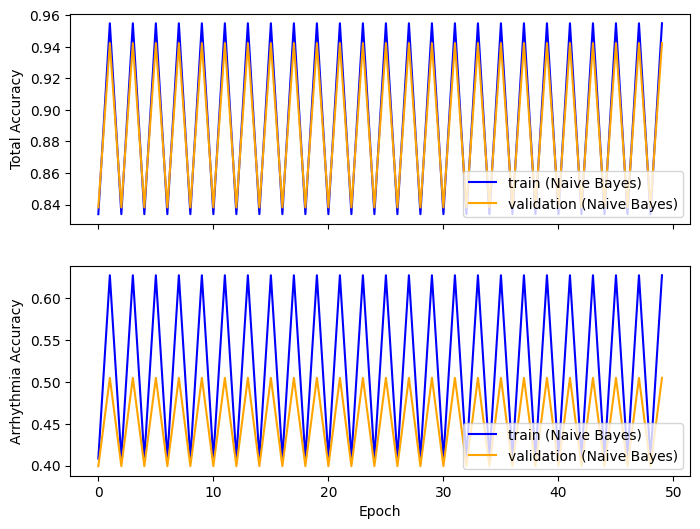

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

gnb = GaussianNB()
svc = SVC()

# create lists to store accuracies
train_acc_t, train_acc_a = [], []
validation_acc_t, validation_acc_a = [], []

for epoch in depth_range:
    # train classifiers
    gnb.fit(X_train, y_train)
    svc.fit(X_train, y_train)

    # calculate and store accuracy on training set
    train_y_pred_gnb = gnb.predict(X_train)
    train_acc_t_gnb, train_acc_a_gnb = calculate_accuracy(train_y_pred_gnb, y_train, printout=False)
    train_acc_t.append(train_acc_t_gnb)
    train_acc_a.append(train_acc_a_gnb)

    train_y_pred_svc = svc.predict(X_train)
    train_acc_t_svc, train_acc_a_svc = calculate_accuracy(train_y_pred_svc, y_train, printout=False)
    train_acc_t.append(train_acc_t_svc)
    train_acc_a.append(train_acc_a_svc)

    # calculate and store accuracy on validation set
    val_y_pred_gnb = gnb.predict(X_val)
    val_acc_t_gnb, val_acc_a_gnb = calculate_accuracy(val_y_pred_gnb, y_val, printout=False)
    validation_acc_t.append(val_acc_t_gnb)
    validation_acc_a.append(val_acc_a_gnb)

    val_y_pred_svc = svc.predict(X_val)
    val_acc_t_svc, val_acc_a_svc = calculate_accuracy(val_y_pred_svc, y_val, printout=False)
    validation_acc_t.append(val_acc_t_svc)
    validation_acc_a.append(val_acc_a_svc)

# plot accuracies
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
ax[0].plot(train_acc_t, label='train (Naive Bayes)', color='blue')
ax[0].plot(validation_acc_t, label='validation (Naive Bayes)', color='orange')
ax[0].set_ylabel('Total Accuracy')
ax[0].legend(loc='lower right')
ax[1].plot(train_acc_a, label='train (Naive Bayes)', color='blue')
ax[1].plot(validation_acc_a, label='validation (Naive Bayes)', color='orange')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Arrhythmia Accuracy')
ax[1].legend(loc='lower right')
plt.show()


1 0.8592 0.2428
2 0.0860 0.7572
3 0.8280 0.3994
4 0.7852 0.4377
5 0.8313 0.4760
6 0.7290 0.6070
7 0.8338 0.5942
8 0.8302 0.6326
9 0.8607 0.6070
10 0.7790 0.6613
11 0.8342 0.6709
12 0.8494 0.6550
13 0.8179 0.6837
14 0.8364 0.6869
15 0.8229 0.6645
16 0.8418 0.6613
17 0.8378 0.6645
18 0.8378 0.6741
19 0.8393 0.6613
20 0.8451 0.6581
21 0.8523 0.6645
22 0.8516 0.6581
23 0.8516 0.6581
24 0.8509 0.6645
25 0.8516 0.6677


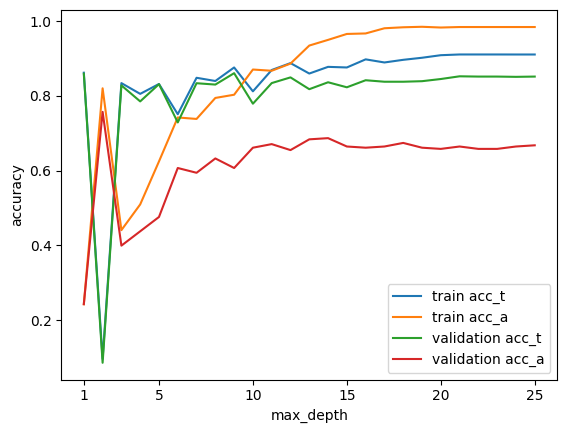

In [ ]:
# tunning max_dept hyperparameter (DT likes to overfit)
train_acc_t = []
train_acc_a = []
val_acc_t = []
val_acc_a = []
depth_range = range(1,26)
for max_depth in depth_range:
    dtc = DecisionTreeClassifier(criterion='entropy', 
                                 class_weight='balanced', 
                                 min_samples_leaf=10,
                                 max_depth=max_depth)
    dt_fit = dtc.fit(X_train, y_train)
    y_pred_train = dt_fit.predict(X_train)
    y_pred_val = dt_fit.predict(X_val)    
    acc_t_train, acc_a_train = calculate_accuracy(y_pred_train, y_train, printout=False)
    acc_t_val, acc_a_val = calculate_accuracy(y_pred_val, y_val, printout=False)
    train_acc_t.append(acc_t_train)
    train_acc_a.append(acc_a_train)
    val_acc_t.append(acc_t_val)
    val_acc_a.append(acc_a_val)
    print('{0:d} {1:.4f} {2:4.4f}'.format(max_depth, acc_t_val, acc_a_val))

import matplotlib.pyplot as plt
_, ax = plt.subplots()
ax.plot(depth_range, train_acc_t, label='train acc_t')
ax.plot(depth_range, train_acc_a, label='train acc_a')
ax.plot(depth_range, val_acc_t, label='validation acc_t')
ax.plot(depth_range, val_acc_a , label='validation acc_a')
ax.set(xlabel='max_depth', ylabel='accuracy')
ax.xaxis.set_ticks([1, 5, 10, 15, 20, 25])
ax.legend()
plt.show()